In [35]:
import rioxarray as rix
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import shape
from shapely.ops import unary_union
import geopandas as gpd
import numpy as np
import xarray as xr

# Plot for all years

In [23]:
def open_and_extract_date_from_filename(filepath):
    ds = rix.open_rasterio(filepath)
    ds.attrs['original_filename'] = os.path.basename(filepath)
    ds.attrs['date'] = os.path.basename(filepath)[:10]
    return ds

img_2020 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2020_psscene_analytic_sr_udm2/2020-05-02_strip_3365031_composite_file_format.tif")
img_2021 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2021_psscene_analytic_sr_udm2/2021-04-29_strip_4427235_composite_file_format.tif")
img_2022 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2022_psscene_analytic_sr_udm2/2022-05-06_strip_5620315_composite_file_format.tif")
img_2023 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2023_psscene_analytic_sr_udm2/2023-05-16_strip_6512704_composite_file_format.tif")
img_2024 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2024_psscene_analytic_sr_udm2/2024-05-02_strip_7279988_composite_file_format.tif")
img_2025 = open_and_extract_date_from_filename("/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2025_psscene_analytic_sr_udm2/2025-04-25_strip_8025643_composite_file_format.tif")

<Axes: >

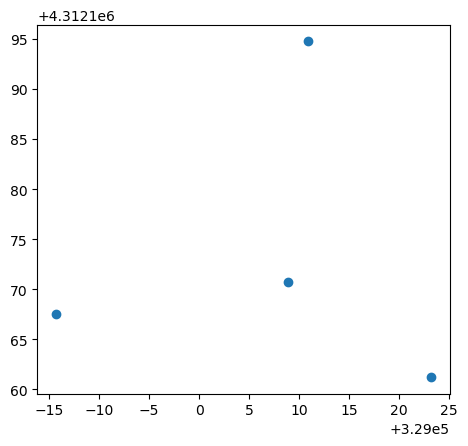

In [24]:
towers_gdf = gpd.read_file("./landsat_data/towers.geojson").to_crs(img_2020.rio.crs)
towers_gdf.plot()

In [25]:
central_point = towers_gdf.set_index('Tower').loc['c'].geometry
from shapely.geometry import box
x, y = central_point.x, central_point.y
bounding_box = gpd.GeoDataFrame(
    geometry = [box(x - 100, y - 100, x + 100, y + 100)],
)
bounding_box

,geometry
0,"POLYGON ((329108.911 4312070.778, 329108.911 4..."


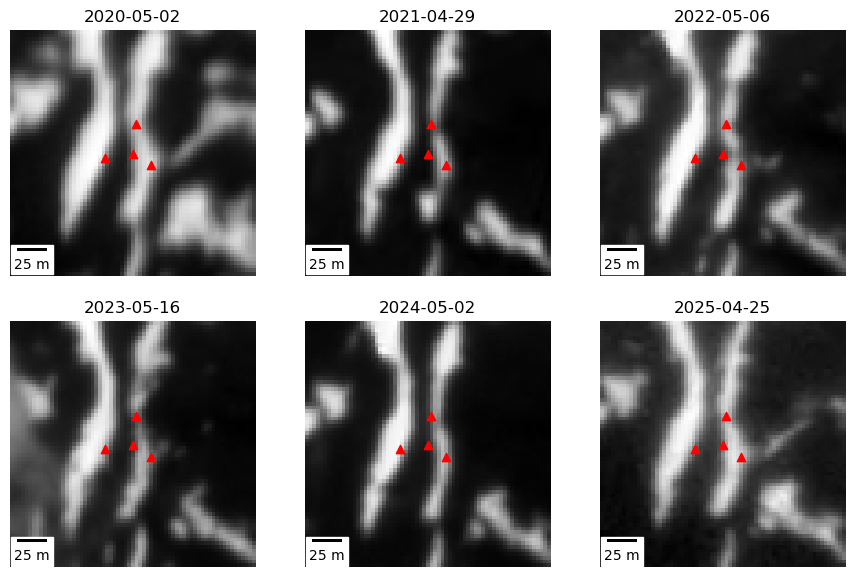

In [26]:
images = [ ('2020', img_2020), ('2021', img_2021), ('2022', img_2022), ('2023', img_2023), ('2024', img_2024), ('2025', img_2025), ]
# Crop all images
cropped_images = [(yr, img.rio.clip(bounding_box.geometry)) for yr, img in images]

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for ax, (yr, cropped_img) in zip(axes, cropped_images):
    cropped_img.sel(band=1).plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^')
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

# ADD LIDAR OUTLINE

In [27]:
ls lidar_data

20230515.tif                    l2_elevation_20230523_1200.tif
20230530.tif                    l2_elevation_20230530_0000.tif
__pycache__/                    l6_elevation_20230515_0000.tif
convert_from_lvx_to_pcd.ipynb   l6_elevation_20230516_0000.tif
correct_lidar.py                l6_elevation_20230523_0000.tif
extract_e_melt.ipynb            l6_elevation_20230530_0000.tif
l2_elevation_20230515_0000.tif  lidar_reader.ipynb
l2_elevation_20230515_1200.tif  lvx_reader.py
l2_elevation_20230516_0000.tif  read_csf_dsms.ipynb
l2_elevation_20230516_1200.tif  read_dsms.ipynb
l2_elevation_20230523_0000.tif  read_dsms_l6.ipynb


In [28]:
lidar_l2 = rix.open_rasterio("lidar_data/l2_elevation_20230515_0000.tif")
lidar_l6 = rix.open_rasterio("lidar_data/l6_elevation_20230515_0000.tif")

<Axes: >

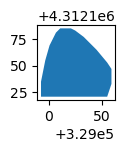

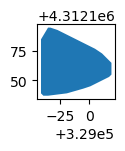

In [29]:
src_raster = lidar_l2.sel(band=1).astype('float32').rio.reproject(
    lidar_l2.rio.crs,
    resolution = (2,2)
)
src_raster.rio.to_raster('l2.tif')

src_raster = lidar_l6.sel(band=1).astype('float32').rio.reproject(
    lidar_l6.rio.crs,
    resolution = (2,2)
)
src_raster.rio.to_raster('l6.tif')


import rasterio
from rasterio.features import shapes
from shapely.geometry import shape

from geopandas import GeoDataFrame
from pandas import DataFrame


with rasterio.open('l2.tif') as src:
    data_l2 = src.read(1, masked=True)
    # Use a generator instead of a list
    shape_gen_l2 = ((shape(s), v) for s, v in shapes(data_l2, transform=src.transform))
    # or build a dict from unpacked shapes
    gdf_l2 = GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen_l2))), crs=src.crs)

# # Step 3: Perform a union on all geometries
union_geometry_l2 = unary_union(gdf_l2.geometry)
# # Step 4: Extract the convex hull
convex_hull_l2 = union_geometry_l2.convex_hull

with rasterio.open('l6.tif') as src:
    data_l6 = src.read(1, masked=True)
    # Use a generator instead of a list
    shape_gen_l6 = ((shape(s), v) for s, v in shapes(data_l6, transform=src.transform))
    # or build a dict from unpacked shapes
    gdf_l6 = GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen_l6))), crs=src.crs)

# # Step 3: Perform a union on all geometries
union_geometry_l6 = unary_union(gdf_l6.geometry)
# # Step 4: Extract the convex hull
convex_hull_l6 = union_geometry_l6.convex_hull

lidar_outline_gdf_l2 = gpd.GeoDataFrame(geometry=[convex_hull_l2])
lidar_outline_gdf_l2.plot(figsize=(1,1))
lidar_outline_gdf_l6 = gpd.GeoDataFrame(geometry=[convex_hull_l6])
lidar_outline_gdf_l6.plot(figsize=(1,1))

# ADD PROFILE LINES

In [30]:
profile_lines_fn = "/Users/elischwat/Downloads/snow_patch_profiles.shp"
profile_lines_gdf = gpd.read_file(profile_lines_fn)
profile_lines_gdf = profile_lines_gdf.iloc[[0, 1, 2, 4, 5, 8]]

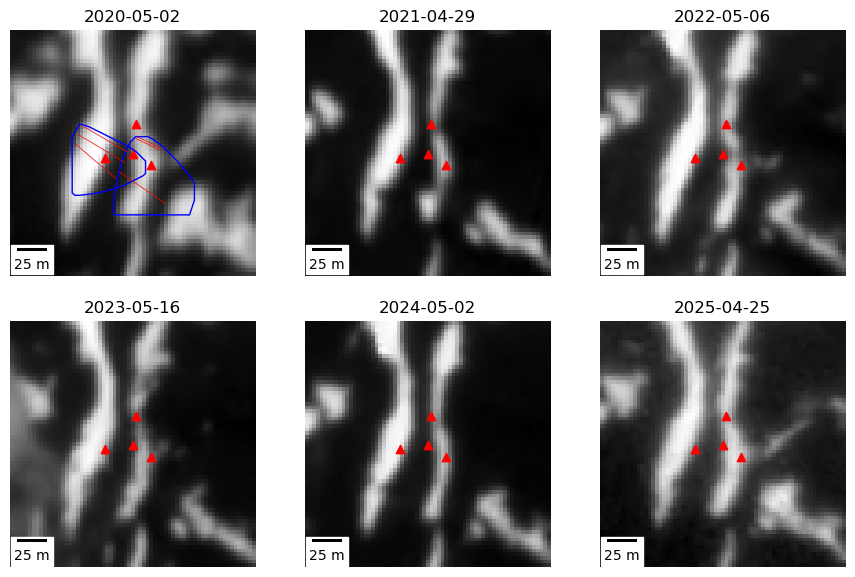

In [31]:
images = [ ('2020', img_2020), ('2021', img_2021), ('2022', img_2022), ('2023', img_2023), ('2024', img_2024), ('2025', img_2025), ]
# Crop all images
cropped_images = [(yr, img.rio.clip(bounding_box.geometry)) for yr, img in images]

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for ax, (yr, cropped_img) in zip(axes, cropped_images):
    cropped_img.sel(band=1).plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^', label='Towers', legend=True)  # Add legend for towers
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

lidar_outline_gdf_l2.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
lidar_outline_gdf_l6.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='blue', facecolor='none')
profile_lines_gdf.plot(ax=axes[0], figsize=(1,1), alpha =1.0, edgecolor='red', facecolor='none', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot for 2023

In [32]:
ls/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2023_psscene_analytic_sr_udm2/ | grep _composite_file_format.tif | grep -v .aux.xml

2023-05-05_strip_6484934_composite_file_format.tif
2023-05-05_strip_6485291_composite_file_format.tif
2023-05-05_strip_6485512_composite_file_format.tif
2023-05-06_strip_6487521_composite_file_format.tif
2023-05-06_strip_6487709_composite_file_format.tif
2023-05-08_strip_6492890_composite_file_format.tif
2023-05-08_strip_6493897_composite_file_format.tif
2023-05-09_strip_6495899_composite_file_format.tif
2023-05-10_strip_6497912_composite_file_format.tif
2023-05-13_strip_6505736_composite_file_format.tif
2023-05-15_strip_6510381_composite_file_format.tif
2023-05-16_strip_6512704_composite_file_format.tif
2023-05-23_strip_6528815_composite_file_format.tif
2023-05-29_strip_6542533_composite_file_format.tif
2023-05-31_strip_6547216_composite_file_format.tif


In [33]:
base_dir = "/Users/elischwat/Development/data/sublimationofsnow/planet_imagery/gothic-co-meltout-2023_psscene_analytic_sr_udm2/"
img_ls_2023 = [
    '2023-05-09_strip_6495899_composite_file_format.tif',
    '2023-05-10_strip_6497912_composite_file_format.tif',
    '2023-05-13_strip_6505736_composite_file_format.tif',
    '2023-05-15_strip_6510381_composite_file_format.tif',
    '2023-05-16_strip_6512704_composite_file_format.tif',
    '2023-05-23_strip_6528815_composite_file_format.tif',
]
img_ls_2023 = [open_and_extract_date_from_filename(os.path.join(base_dir, f)) for f in img_ls_2023]

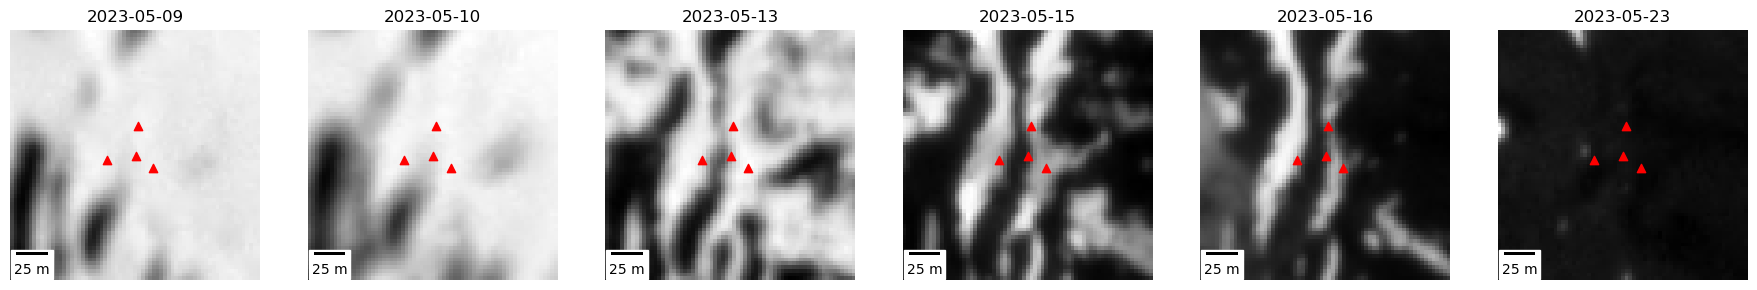

In [34]:
# Crop all images
cropped_images = [(img.rio.clip(bounding_box.geometry)) for img in img_ls_2023]

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes = axes.flatten()

for ax, (cropped_img) in zip(axes, cropped_images):
    cropped_img.sel(band=1).plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^')
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

In [67]:
def get_normed_rgb_img(ds):
    # Stack the RGB bands (e.g., bands 1, 2, and 3)
    rgb_image = np.stack([
        ds.sel(band=3),  # Red
        ds.sel(band=2),  # Green
        ds.sel(band=1)   # Blue
    ], axis=-1)

    # Normalize the RGB image to [0, 1] for display
    rgb_image = rgb_image / rgb_image.max()
    return rgb_image

rgb_img_ls_2023 = [get_normed_rgb_img(img.rio.clip(bounding_box.geometry)) for img in img_ls_2023]

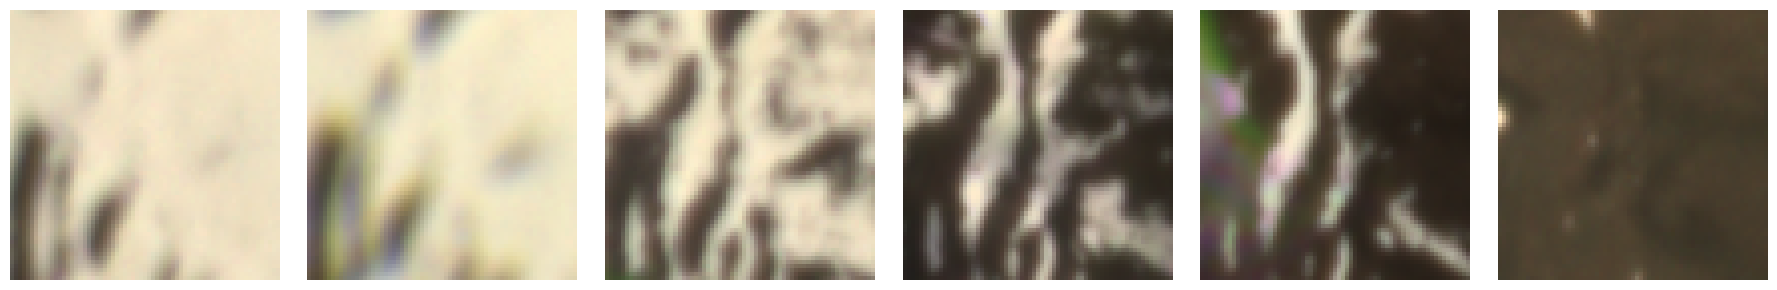

In [77]:

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes = axes.flatten()

for ax, (cropped_img) in zip(axes, rgb_img_ls_2023):
    # cropped_img.sel(band=1).plot(ax=ax, cmap='grey', add_colorbar=False)
    ax.imshow(cropped_img)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    # ax.set_title(cropped_img.attrs['date'])
    # towers_gdf.plot(ax=ax, color='red', marker='^')
    # scalebar = ScaleBar(1, location="lower left")
    # ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

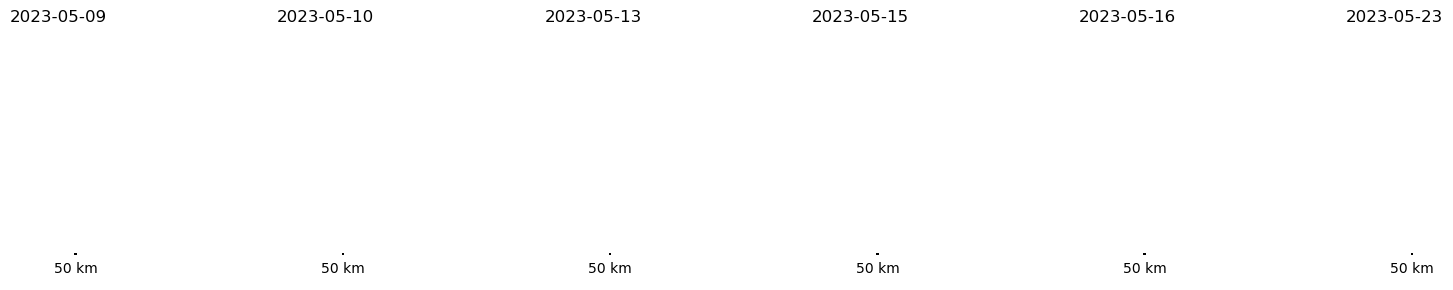

In [53]:
# Crop all images
cropped_images = [(img.rio.clip(bounding_box.geometry)) for img in img_ls_2023]

# Plot the images in a 3x2 grid
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes = axes.flatten()

for ax, cropped_img in zip(axes, cropped_images):
    # Stack bands 1, 2, and 3 for RGB visualization
    rgb_image = np.stack([
        cropped_img.sel(band=3),
        cropped_img.sel(band=2),
        cropped_img.sel(band=1),
    ], axis=-1)
    
    # Plot the RGB image
    ax.imshow(rgb_image / rgb_image.max())  # Normalize to [0, 1]
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis
    ax.set_title(cropped_img.attrs['date'])
    towers_gdf.plot(ax=ax, color='red', marker='^')
    scalebar = ScaleBar(1, location="lower left")
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

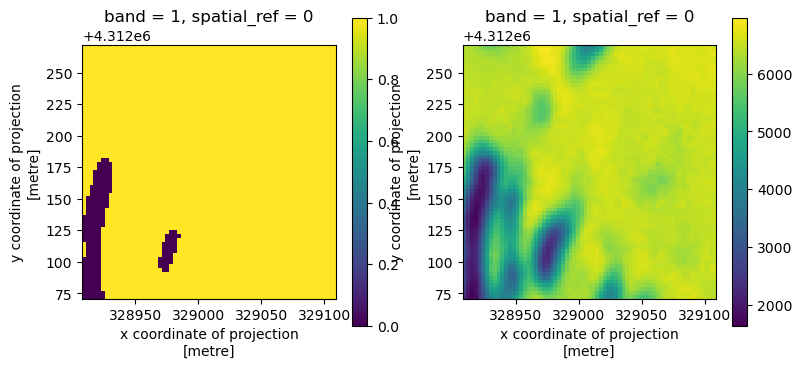

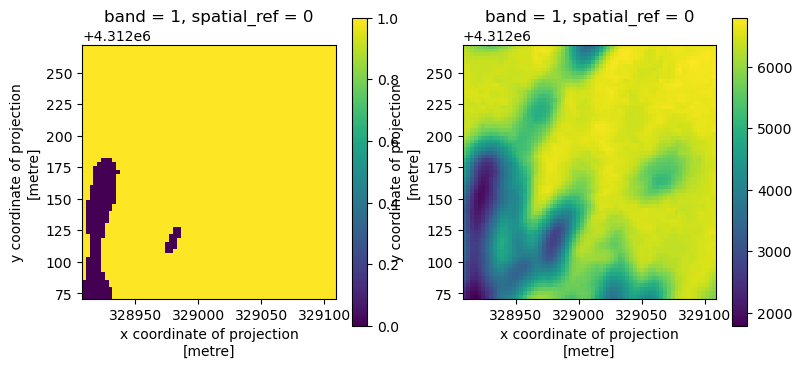

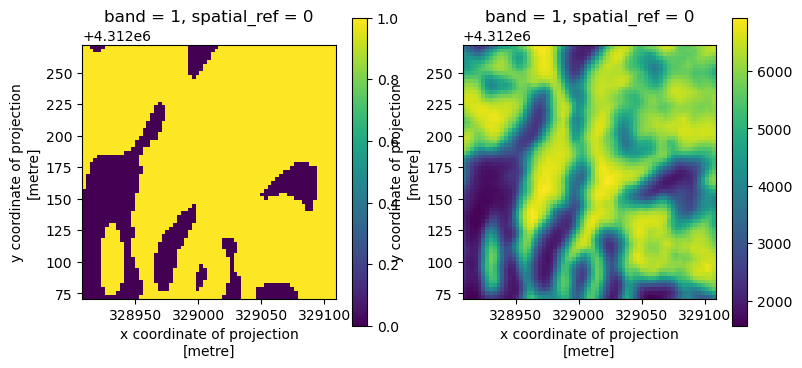

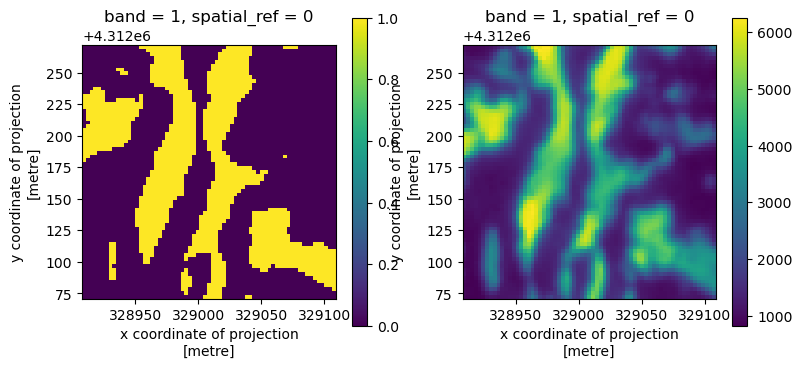

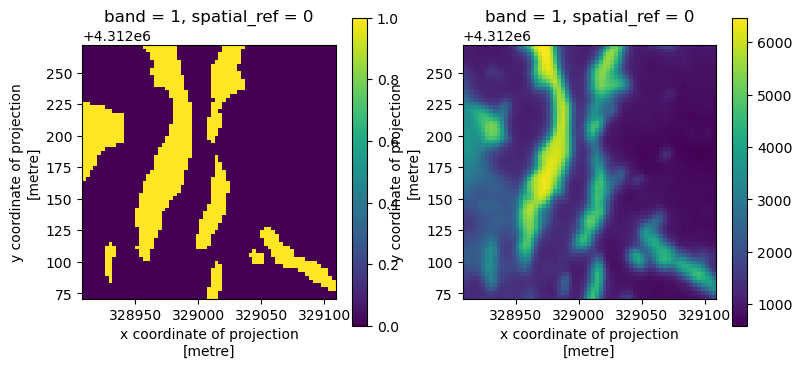

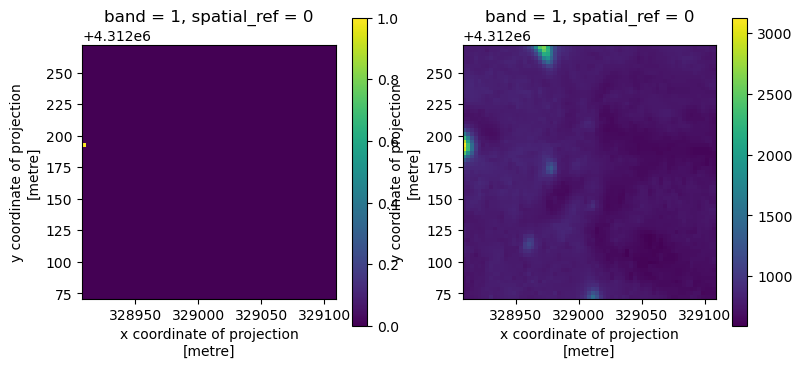

In [50]:
for img in img_ls_2023:


    # Clip the image and select the band
    image_band = img.rio.clip(bounding_box.geometry).sel(band=1)

    # Apply binary classification (e.g., threshold = 100)
    threshold = 3000
    binary_image = xr.where(image_band > threshold, 1, 0)

    fig, axes = plt.subplots(1,2, figsize=(9,4))
    # Plot the binary-classified image
    binary_image.plot(ax=axes[0])
    img.rio.clip(bounding_box.geometry).sel(band=1).plot(ax=axes[1])
    for ax in axes:
        ax.set_aspect('equal')
    plt.show()